## Quantile Regression

The goal of this notebook is to understand the loss function and validation metrics used for the validation of prediction intervals in regression problems.

In [1]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from scipy.stats import norm
from sklearn import ensemble

import tensorflow as tf
from tensorflow import keras
tf.get_logger().setLevel('INFO')

mpl.rcParams['figure.figsize'] = 20, 10

## Introduction

<a id='intro'>Introduction to Quantile Regression and Loss function</a>

In **quantile regression** instead of minimising the squared-error loss function, we minimized the **quantile loss**

### Quantile Loss

##### Loss individual data point

$$
\begin{align}
\mathcal{L}(\xi_i|\alpha)=\begin{cases}
\alpha \xi_i &\text{if }\xi_i\ge 0, \\
(\alpha-1) \xi_i &\text{if }\xi_i< 0.
\end{cases}
\end{align}
$$

* $\alpha$: the required quantile (a value between 0 and 1)
* $\xi_i = y_i - f(\mathbf{x}_i)$
* $f(\mathbf{x}_i)$ is the predicted (quantile)

##### Loss function

$$\mathcal{L}(\mathbf{y},\mathbf{f}|\alpha)=\frac{1}{N} \sum_{i=1}^N \mathcal{L}(y_i-f(\mathbf{x}_i)|\alpha)$$

In [2]:
def quantile_loss(q, y, f):
    # q: Quantile to be evaluated, e.g., 0.5 for median.
    # y: True value.
    # f: Fitted or predicted value.
    e = f - y
    #e = y - f . NOTE: IMPORTANT!! Sometimes the error is computed in this form 
    return np.maximum(q * e, (q - 1) * e)

#### Intuitive interpretation


* *Overpredicting* f > y. The error will be positive and the first term will dominate 
* *Underpredicting* f < y. The error will be negative and the second term will dominate

Q is a penalization factor
 * q=0.5 under-prediction and over-prediction will be penalized by the same factor, the median is obtained
 * q=0.75 over-predictions will be penalized by a factor of 0.75, and under-predictions by a factor of 0.25


*Important Note!!!: In the interpretation has been taken as a reference the [post](https://medium.com/analytics-vidhya/prediction-intervals-in-forecasting-quantile-loss-function-18f72501586f), since there are various interpretation depending on the computation of the error*

In [11]:
quantile_loss_error = np.linspace(-1, 1, 1000)
quantile_loss_error_loss_10 = quantile_loss(0.1, 0, quantile_loss_error)
quantile_loss_error_loss_30 = quantile_loss(0.3, 0, quantile_loss_error)
quantile_loss_error_loss_50 = quantile_loss(0.5, 0, quantile_loss_error)
quantile_loss_error_loss_70 = quantile_loss(0.7, 0, quantile_loss_error)
quantile_loss_error_loss_90 = quantile_loss(0.9, 0, quantile_loss_error)

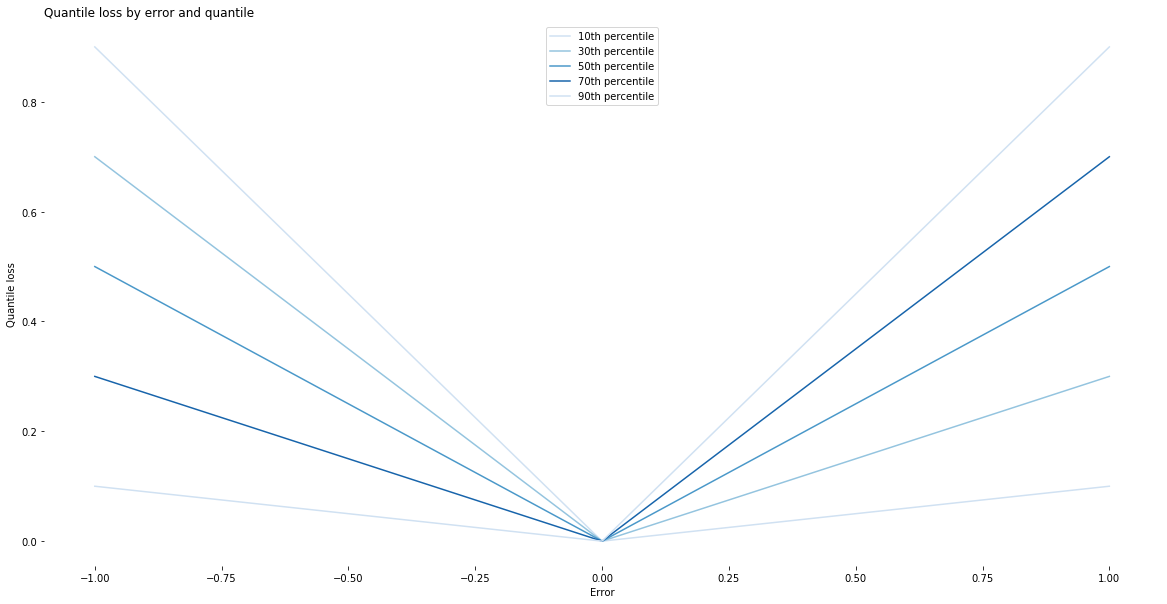

In [12]:
with sns.color_palette('Blues', 4):
    plt.plot(quantile_loss_error, quantile_loss_error_loss_10)
    plt.plot(quantile_loss_error, quantile_loss_error_loss_30)
    plt.plot(quantile_loss_error, quantile_loss_error_loss_50)
    plt.plot(quantile_loss_error, quantile_loss_error_loss_70)
    plt.plot(quantile_loss_error, quantile_loss_error_loss_90)
    plt.legend([str(int(q * 100)) + 'th percentile' for q in [0.1, 0.3, 0.5, 0.7, 0.9]])
    sns.despine(left=True, bottom=True)
    plt.xlabel('Error')
    plt.ylabel('Quantile loss')
    plt.title('Quantile loss by error and quantile', loc='left');

In this chart, it is artificially generated error values in a interval of [-1,1] in order to understand how the quantile loss function behaves. 


As we can see, the quantile loss differs depending on the evaluated quantile. For the case of the quantile 50th the error is symmetric in both sides of [-1,0] and [0,1] so the errors comming from the observations both sides (overpredictting and underpredictting) are penalized equally. 

More positive errors are penalized more for higher quantiles and more negative errors are penalized more for lower quantiles. 

#### Why use Quantile Loss?

- The conditions of linear regression are not met (i.e., linearity, homoscedasticity, independence, or normality)
    * No assumptions about the *distribution of residuals*
    * The dependent variable is multimodal and we don't know what caused the *multimodality* (not able to perform stratified analysis)
    * The data distribution is *highly skewed*, we would like to predict top quantiles (median) than the mean
    * Substantive interest in the *highest and lowest quantiles* (i.e. studying the spread of sexually transmitted diseases)